In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, models, optimizers
from tensorflow.keras.layers import TimeDistributed, Conv2D, Flatten, Dense, LSTM, ConvLSTM2D, MaxPool2D, Dropout, Conv1D
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.compat.v1.enable_eager_execution()

In [5]:
inputs_train = np.load("inputs_train_180.npy")
inputs_test = np.load("inputs_test_180.npy")

In [6]:
inputs_train = np.transpose(inputs_train, (0, 2,3,1))
inputs_test = np.transpose(inputs_test, (0, 2,3,1))

In [7]:
inputs_train = inputs_train.reshape(inputs_train.shape[:2] + (inputs_train.shape[2]*inputs_train.shape[3],))
inputs_test = inputs_test.reshape(inputs_test.shape[:2] + (inputs_test.shape[2]*inputs_test.shape[3],))

In [7]:
window_size = 180

In [8]:
train = pd.read_csv('train_timeframes.csv').iloc[window_size-1:]
test = pd.read_csv('test_timeframes.csv').iloc[window_size-1:]

In [9]:
df = [train, test]

In [10]:
img = inputs_train[0,:,:]

In [96]:
img.shape

(180, 4)

In [11]:
inputs_train.shape, train.shape

((73516, 180, 4), (73575, 23))

In [12]:
inputs_test.shape, test.shape

((24186, 180, 4), (24245, 23))

In [13]:
idx = 0
batch_size = 32
stop_limit = 0.0100
price_limit = 0.0500
margin_size = 50
time_limit = 120

In [14]:
def get_model():
    model = models.Sequential()
    # model.add(LSTM(64, input_shape = img.shape, return_sequences=True, dropout=0.2))
    model.add(LSTM(32, input_shape = img.shape, dropout=0.5))
    # model.add(LSTM(32, dropout=0.2))
    model.add(Dense(3, activation = "tanh"))
    return model

model = get_model()

In [194]:
# model = tf.keras.models.load_model('profit_model/', compile=False)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6784      
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 6,883
Trainable params: 6,883
Non-trainable params: 0
_________________________________________________________________


In [19]:
buffer_train = train.shape[0] - inputs_train.shape[0] +time_limit - 1
buffer_test = test.shape[0] - inputs_test.shape[0] +time_limit - 1

In [21]:
all_closes_train = tf.convert_to_tensor([df[0].iloc[i:i+1+time_limit]['close_1min'].tolist() for i in range(len(df[0])-buffer_train)])
all_closes_test = tf.convert_to_tensor([df[1].iloc[i:i+1+time_limit]['close_1min'].tolist() for i in range(len(df[1])-buffer_test)])

In [22]:
all_spread_train = tf.convert_to_tensor([df[0].iloc[i:i+1]['spread'].tolist() for i in range(len(df[0])-buffer_train)])
all_spread_test = tf.convert_to_tensor([df[1].iloc[i:i+1]['spread'].tolist() for i in range(len(df[1])-buffer_test)])

In [147]:
np.save(open('all_closes_train', 'wb'), all_closes_train.numpy())
np.save(open('all_closes_test', 'wb'), all_closes_test.numpy())
np.save(open('all_spread_train', 'wb'), all_spread_train.numpy())
np.save(open('all_spread_test', 'wb'), all_spread_test.numpy())

In [16]:
all_closes_train = tf.convert_to_tensor(np.load('all_closes_train.npy'))
all_closes_test = tf.convert_to_tensor(np.load('all_closes_test.npy'))
all_spread_train = tf.convert_to_tensor(np.load('all_spread_train.npy'))
all_spread_test = tf.convert_to_tensor(np.load('all_spread_test.npy'))

In [23]:
all_closes_train.shape, all_spread_train.shape

(TensorShape([73397, 121]), TensorShape([73397, 1]))

In [53]:
def custom_loss_wrapper(idx, stop_limit, price_limit, margin_size):  
    def custom_loss(y_true, y_pred):
        #margin = ((y_pred[:,:1] - 0.5) * 2)
        #margin *= margin_size
        margin = y_pred[:,:1] #* direction * -1 * stop_limit
        direction = tf.sign(margin)
        stop_loss = ((y_pred[:,1:2] + 1) / 2) * direction * -1 * stop_limit
        price_target = ((y_pred[:,2:3] + 1) / 2) * direction * 1 * price_limit
        
        idxs = y_true[:,1]
        df_name = y_true[0][0]
        closes = tf.cond(df_name == tf.constant(0), lambda: tf.gather(all_closes_train, idxs), lambda: tf.gather(all_closes_test, idxs))
        spread = tf.cond(df_name == tf.constant(0), lambda: tf.gather(all_spread_train, idxs), lambda: tf.gather(all_spread_test, idxs))
        close1 = closes[:,:1]
        close2 = tf.zeros_like(closes[:,:1])
        i = tf.constant(0)
        def while_condition(i, close2): 
            return tf.less(i, tf.constant(closes.shape[1]))
        def body(i, close2):
            s = tf.slice(closes, [0, i], [-1, 1])
            diff = (s  - close1) * direction
            cond = tf.logical_or(tf.less(diff, stop_loss), tf.greater(diff, price_target))
            close2 = tf.where(tf.logical_and(tf.equal(close2, 0), cond), s, close2)
            return [tf.add(i, 1), close2]
        r = tf.while_loop(while_condition, body, [i, close2], parallel_iterations=closes.shape[1], swap_memory=True)#, shape_invariants=[0, close2])
            
        close2 = tf.where(tf.equal(close2, 0), closes[:,-1:], close2)

        diff = close2 - close1
        profit = -100 * (margin * margin_size * (diff - (spread*direction))) /  close1
        return profit
#         return tf.where(tf.less(tf.abs(profit), 1), tf.sign(profit)*tf.sqrt(tf.abs(profit)), profit)
    return custom_loss

In [99]:
def get_profit(data, y_preds, margin_lower_limit=0):
    idx = 0
    profits = []
    while idx < len(y_preds) - 1:
        margin = ((y_preds[idx][0] - 0.5) * 2)
        margin *= margin_size
        if abs(margin) < margin_lower_limit:
            idx += 1
        else:
            direction = np.sign(margin)
            stop_loss = ((y_preds[idx,1] + 1) / 2) * direction * -1 * stop_limit
            price_target = ((y_preds[idx,2] + 1) / 2) * direction * 1 * price_limit

            start_idx = idx
            close1 =  data.iloc[idx]['close_1min']
            spread = data.iloc[idx]['spread']
            idx += 1
            new_i = idx
            while new_i < len(data) - 1 and new_i - start_idx < time_limit:
                close2 = data.iloc[new_i]['close_1min']
                diff = (close2 - close1) 
                if min(stop_loss, price_limit) < diff * direction < max(stop_loss, price_limit):
                    break
                new_i += 1
            profit = 100 * (margin * (diff - (spread*direction))) /  close1
#             print(profit)
            profits.append(profit)
#             break
    return profits

# data = df[]

In [59]:
from keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=10):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
#             score = np.mean(custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)(tf.convert_to_tensor(self.y_val), tf.convert_to_tensor(y_pred)))
#             profits = get_profit(df[1], y_pred)
#             profits_0 = get_profit(df[1], y_pred, 0)
            print(np.min(y_pred, axis=0))
            print(np.mean(y_pred, axis=0))
            print(np.max(y_pred, axis=0))
#             print("interval evaluation - epoch: {:d} - score: {:.6f} -- score_0: {:.6f}".format(epoch, profits, profits_0))
           
buffer = (batch_size+time_limit) + 1000
ival = IntervalEvaluation(validation_data=(inputs_test[:-buffer], np.array([[1, i] for i in range(len(test)-buffer)])), interval=10)

In [60]:
model = get_model()

In [61]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001, epsilon=1.0),
    loss=custom_loss_wrapper(idx, stop_limit, price_limit, margin_size),
#     metrics=[custom_metric_wrapper(idx, stop_limit, price_limit, margin_size, time_limit)],
    run_eagerly=False
)

In [62]:
history = model.fit(
    tf.convert_to_tensor(inputs_train[:-buffer_train]), 
    tf.convert_to_tensor([[0, i] for i in range(len(inputs_train)-buffer_train)]), 
    validation_data=(tf.convert_to_tensor(inputs_test[:-buffer_test]), tf.convert_to_tensor([[1, i] for i in range(len(inputs_test)-buffer_test)])),
    epochs=10000, shuffle=True,
    batch_size=batch_size,
    callbacks=[ival],
    use_multiprocessing=True, verbose=1, 
    validation_freq=10,
    workers=64,
#     initial_epoch=model.history.epoch[-1],
)

Epoch 1/10000
2292/2292 [==============================] - 64s 27ms/step - loss: -0.6296
[-0.28555876 -0.16894011 -0.30899078]
[ 0.42463735 -0.05549951 -0.18300852]
[0.85618305 0.06603079 0.02622559]
Epoch 2/10000
2292/2292 [==============================] - 65s 29ms/step - loss: -2.5174
Epoch 3/10000
2292/2292 [==============================] - 65s 28ms/step - loss: -3.7100
Epoch 4/10000
2292/2292 [==============================] - 65s 28ms/step - loss: -4.0159
Epoch 5/10000
2292/2292 [==============================] - 66s 29ms/step - loss: -4.2797
Epoch 6/10000
2292/2292 [==============================] - 65s 28ms/step - loss: -4.4289
Epoch 7/10000
2292/2292 [==============================] - 65s 29ms/step - loss: -4.4897
Epoch 8/10000
2292/2292 [==============================] - 65s 28ms/step - loss: -4.4895
Epoch 9/10000
2292/2292 [==============================] - 65s 28ms/step - loss: -4.5713
Epoch 10/10000
2292/2292 [==============================] - 72s 31ms/step - loss: -4.489

2292/2292 [==============================] - 64s 28ms/step - loss: -5.6269
Epoch 159/10000
2292/2292 [==============================] - 64s 28ms/step - loss: -5.4243
Epoch 160/10000
2292/2292 [==============================] - 70s 31ms/step - loss: -5.4686 - val_loss: -3.8086
Epoch 161/10000
2292/2292 [==============================] - 64s 28ms/step - loss: -5.4089
[-0.9999989  -0.43061218 -0.7267279 ]
[ 0.15682934  0.11809692 -0.09958671]
[0.99999833 0.6132659  0.44384393]
Epoch 162/10000
2292/2292 [==============================] - 64s 28ms/step - loss: -5.6229
Epoch 163/10000
2292/2292 [==============================] - 64s 28ms/step - loss: -5.5323
Epoch 164/10000
2292/2292 [==============================] - 64s 28ms/step - loss: -5.6062
Epoch 165/10000
2292/2292 [==============================] - 64s 28ms/step - loss: -5.6255
Epoch 166/10000
2292/2292 [==============================] - 64s 28ms/step - loss: -5.4345
Epoch 167/10000
2292/2292 [==============================] - 64s 2

KeyboardInterrupt: 

In [112]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [113]:
import keras
keras.__version__

'2.4.3'

In [76]:
model.save('profit_model_fast')

INFO:tensorflow:Assets written to: profit_model_fast\assets


INFO:tensorflow:Assets written to: profit_model_fast\assets


In [90]:
import json
weights_list = model.get_weights()
json.dump([w.tolist() for w in weights_list], open('profit_model_fast_weights.json', 'w'))

In [110]:
inputs_train[0]

array([[0.97965571, 0.98591549, 0.89514867, 0.91236307],
       [0.91236307, 0.98122066, 0.91236307, 0.98122066],
       [0.97965571, 0.99843505, 0.96400626, 0.99530516],
       [0.99374022, 1.        , 0.94992175, 0.9514867 ],
       [0.95305164, 0.96713615, 0.94835681, 0.96557121],
       [0.96557121, 0.97809077, 0.9514867 , 0.96713615],
       [0.96557121, 0.97026604, 0.93114241, 0.9342723 ],
       [0.9342723 , 0.94992175, 0.91079812, 0.92018779],
       [0.91862285, 0.93114241, 0.87636933, 0.9029734 ],
       [0.90453834, 0.91236307, 0.85446009, 0.90766823],
       [0.90923318, 0.94209703, 0.90923318, 0.93270736],
       [0.93114241, 0.9342723 , 0.89671362, 0.91392801],
       [0.91236307, 0.91392801, 0.85758998, 0.87636933],
       [0.87480438, 0.90923318, 0.87480438, 0.88888889],
       [0.88732394, 0.88888889, 0.8513302 , 0.86697966],
       [0.86541471, 0.87793427, 0.81846635, 0.86541471],
       [0.86541471, 0.91549296, 0.86541471, 0.90923318],
       [0.91236307, 0.94209703,

In [ ]:
mode

In [111]:
model.predict(inputs_train[:1])

array([[-0.9998713 ,  0.38396364,  0.02222573]], dtype=float32)

In [94]:
y_preds['train']

array([[-0.9998713 ,  0.38396356,  0.02222568],
       [-0.99980795,  0.39179978,  0.02079021],
       [-0.9996873 ,  0.40438262,  0.01821101],
       ...,
       [-0.7010914 ,  0.38647288,  0.23123334],
       [-0.6424865 ,  0.3917611 ,  0.22934084],
       [-0.55829275,  0.39865336,  0.22696523]], dtype=float32)

In [63]:
y_preds = {'train': model.predict(inputs_train[:-buffer]), 'test': model.predict(inputs_test[:-buffer])}

In [100]:
profits = {'train': get_profit(df[0], y_preds['train'], 0), 'test': get_profit(df[1], y_preds['test'], 0)}

In [101]:
temp = {'train': train.iloc[:len(profits['train'])].copy(), 'test': test.iloc[:len(profits['test'])].copy()}
temp['train']['profit'] = profits['train']
temp['test']['profit'] = profits['test']

<AxesSubplot:>

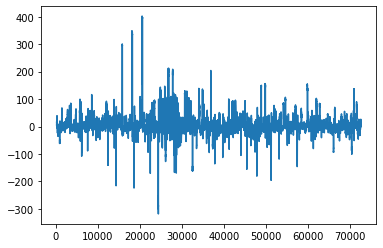

In [102]:
temp['train']['profit'].plot()

<AxesSubplot:>

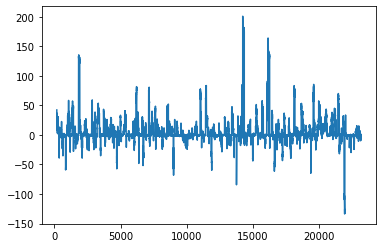

In [103]:
temp['test']['profit'].plot()

<AxesSubplot:>

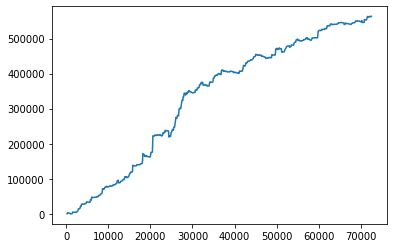

In [104]:
temp['train']['profit'].cumsum().plot()

<AxesSubplot:>

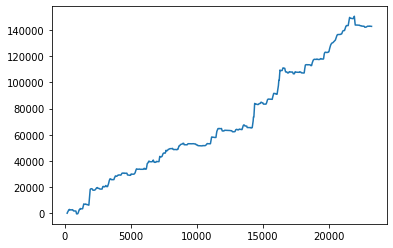

In [105]:
temp['test']['profit'].cumsum().plot()

In [106]:
sum(profits['train'])

563296.8603183313

In [107]:
sum(profits['test'])

142749.83685771326

In [108]:
(252 ** 0.5) * np.mean(profits['train']) / np.std(profits['train'])

3.3293941273754353

In [109]:
(252 ** 0.5) * np.mean(profits['test']) / np.std(profits['test'])

4.192614650142112